In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow

from tensorflow.keras import Sequential

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LSTM

import math

from sklearn.metrics import mean_squared_error

In [2]:
train_data = pd.read_csv("prices-split-adjusted.csv")
train_data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
train_data["symbol"].value_counts()

KSU     1762
NOC     1762
ORCL    1762
OMC     1762
OKE     1762
        ... 
KHC      378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: symbol, Length: 501, dtype: int64

In [4]:
train_data = train_data[train_data["symbol"] == "NOC" ]
train_data.head(20)

,date,symbol,open,close,low,high,volume
559,2010-01-04,NOC,50.686495,51.364120,50.686495,51.382190,1616100.0
1027,2010-01-05,NOC,51.228595,51.454471,51.228595,51.906220,1859800.0
1495,2010-01-06,NOC,51.318946,51.653240,51.129210,51.698415,2204900.0
1963,2010-01-07,NOC,51.427364,52.186308,51.246665,52.367006,4750900.0
2431,2010-01-08,NOC,51.833940,51.897187,51.635170,52.493498,1723700.0
2899,2010-01-11,NOC,52.177270,51.951395,51.680344,52.357973,1523000.0
3367,2010-01-12,NOC,51.716485,52.005605,51.318946,52.032712,1650500.0
3835,2010-01-13,NOC,52.177270,53.568667,52.177270,53.821647,2729700.0
4303,2010-01-14,NOC,53.523489,53.577700,52.918144,54.056556,2044300.0
4771,2010-01-15,NOC,53.360860,52.963318,52.511569,53.496385,1846800.0


In [5]:
train_data.index = train_data["date"]

In [6]:
train_data.drop(["date"],inplace=True,axis=1)

In [7]:
train_data.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,NOC,50.686495,51.364120,50.686495,51.382190,1616100.0
2010-01-05,NOC,51.228595,51.454471,51.228595,51.906220,1859800.0
2010-01-06,NOC,51.318946,51.653240,51.129210,51.698415,2204900.0
2010-01-07,NOC,51.427364,52.186308,51.246665,52.367006,4750900.0
2010-01-08,NOC,51.833940,51.897187,51.635170,52.493498,1723700.0


In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
required_data = train_data["open"].to_numpy()
required_data.shape

(1762,)

In [10]:
required_data = required_data.reshape(-1,1)
required_data.shape

(1762, 1)

In [11]:
minmax = MinMaxScaler(feature_range=(0, 1))
x = minmax.fit_transform(required_data)

In [12]:
## splitting the daata

train_size = int(len(x)*0.7)
test_size = len(x) - train_size

In [13]:
train, test = x[0:train_size,:], x[train_size:len(x),:]
print("Train data length",len(train))
print("Test data length",len(test))

Train data length 1233
Test data length 529


In [14]:
train

array([[0.00928508],
       [0.01195064],
       [0.01239491],
       ...,
       [0.43276312],
       [0.44844869],
       [0.44338408]])

In [15]:
def create_datset(x,look_back=15):
    dataX, dataY = [], []
    
    for i in range(len(x)-look_back-1):
        
        a = x[i:(i+look_back),0]
        dataX.append(a)
        
        dataY.append(x[i+look_back,0])
        
    return np.array(dataX), np.array(dataY)

In [16]:
X_train, y_train = create_datset(train, look_back=15)

X_test, y_test = create_datset(test, look_back=15)

In [17]:
print("X train shape", X_train.shape)
print("Y train shape", y_train.shape)
print("X test shape", X_test.shape)
print("Y test shape", y_test.shape)

X train shape (1217, 15)
Y train shape (1217,)
X test shape (513, 15)
Y test shape (513,)


In [18]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1217, 15, 1)
(1217,)
(513, 15, 1)
(513,)


In [20]:
look_back = 15

lstm_model = Sequential()

lstm_model.add(LSTM(20, input_shape = (look_back, 1)))
lstm_model.add(Dense(1)) #output

lstm_model.compile(loss= 'mean_squared_error', optimizer = 'adam')

In [21]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
lstm_model.fit(X_train,y_train, epochs=20, batch_size = 1, verbose=2)

Epoch 1/20
1217/1217 - 5s - loss: 8.4739e-04 - 5s/epoch - 4ms/step
Epoch 2/20
1217/1217 - 5s - loss: 1.4525e-04 - 5s/epoch - 4ms/step
Epoch 3/20
1217/1217 - 4s - loss: 1.2663e-04 - 4s/epoch - 3ms/step
Epoch 4/20
1217/1217 - 4s - loss: 1.0469e-04 - 4s/epoch - 3ms/step
Epoch 5/20
1217/1217 - 3s - loss: 1.0027e-04 - 3s/epoch - 3ms/step
Epoch 6/20
1217/1217 - 4s - loss: 8.3016e-05 - 4s/epoch - 4ms/step
Epoch 7/20
1217/1217 - 4s - loss: 7.4893e-05 - 4s/epoch - 4ms/step
Epoch 8/20
1217/1217 - 4s - loss: 6.6461e-05 - 4s/epoch - 3ms/step
Epoch 9/20
1217/1217 - 4s - loss: 5.2216e-05 - 4s/epoch - 3ms/step
Epoch 10/20
1217/1217 - 4s - loss: 4.9434e-05 - 4s/epoch - 4ms/step
Epoch 11/20
1217/1217 - 4s - loss: 5.2477e-05 - 4s/epoch - 3ms/step
Epoch 12/20
1217/1217 - 4s - loss: 4.5084e-05 - 4s/epoch - 3ms/step
Epoch 13/20
1217/1217 - 4s - loss: 4.6664e-05 - 4s/epoch - 4ms/step
Epoch 14/20
1217/1217 - 4s - loss: 4.4915e-05 - 4s/epoch - 3ms/step
Epoch 15/20
1217/1217 - 4s - loss: 4.4087e-05 - 4s/epoch 

In [23]:
trainpredict = lstm_model.predict(X_train)
testpredict = lstm_model.predict(X_test)

# invert predictions
trainpredict = minmax.inverse_transform(trainpredict)
trainY = minmax.inverse_transform(y_train)
testpredict = minmax.inverse_transform(testpredict)
testY = minmax.inverse_transform(y_test)

17/17 [==============================] - 0s 2ms/step


In [24]:
print(trainpredict.shape)
print(testpredict.shape)

(1217, 1)

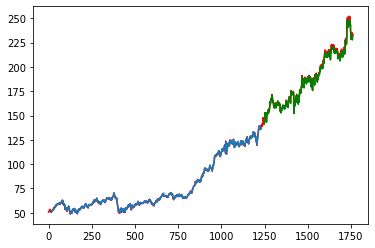

In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(x)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainpredict)+look_back, :] = trainpredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(x)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainpredict)+(look_back*2)+1:len(x)-1, :] = testpredict
# plot baseline and predictions
plt.plot(minmax.inverse_transform(x),'r')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot,'g')
plt.show()

In [29]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainpredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testpredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.05 RMSE
Test Score: 3.05 RMSE
